#### =============================================================================
#### PROJE: DNA Kodon Dataseti Üzerinde Özellik Mühendisliği ve Boyut İndirgeme
#### =============================================================================
#### BU KOD BLOĞU:
#### 1. Veriyi Yükler ve Temizler
#### 2. Eğitim ve Test Setlerine Ayırır (Split)
#### 3. Özellik Mühendisliği (Feature Engineering) Yapar (Biyolojik ve İstatistiksel)
#### 4. Boyut İndirgeme (PCA) Uygular
#### 5. Modellenmeye Hazır Veriyi Kaydeder
#### =============================================================================

Veri Seti Boyutu: (13028, 69)


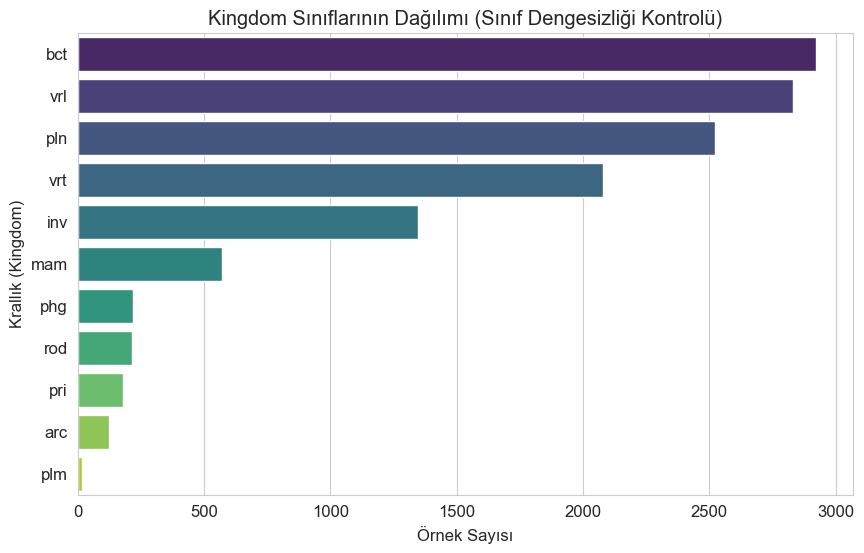

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [37]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from IPython.display import display
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

df = pd.read_csv('C:\\Users\\asus\\OneDrive\\Desktop\\codon_usage.csv', low_memory=False)

print("Veri Seti Boyutu:", df.shape)


plt.figure(figsize=(10, 6))
sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')
plt.title('Kingdom Sınıflarının Dağılımı (Sınıf Dengesizliği Kontrolü)')
plt.xlabel('Örnek Sayısı')
plt.ylabel('Krallık (Kingdom)')
plt.show()

display(df.head())

In [41]:
# ÖN TANIMLAMALAR VE TEMİZLİK
print("\n" + "="*70)
print("Ön Tanımlamalar ve Veri Temizleme")
print("="*70)

# Kodon sütunları (5. sütundan itibaren)
codon_cols = df.columns[5:].tolist()
# Diğer sayısal sütunlar
other_numeric_cols = ['Ncodons', 'DNAtype']
# Tüm sayısal özellikler
numeric_features = codon_cols + other_numeric_cols

print(f"\n Özellik Sayıları:")
print(f"   • Kodon Sütunları: {len(codon_cols)}")
print(f"   • Diğer Sayısal: {len(other_numeric_cols)}")
print(f"   • Toplam Sayısal: {len(numeric_features)}")

# Virgülleri noktaya çevir
print("\n Sayısal formata dönüştürme işlemi...")
for col in numeric_features:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(",", ".", regex=False), 
            errors="coerce"
        )

# Gereksiz sütunları çıkar
df_cleaned = df.drop(columns=['SpeciesID', 'SpeciesName']).copy()
print(" Temizleme tamamlandı!")


Ön Tanımlamalar ve Veri Temizleme

 Özellik Sayıları:
   • Kodon Sütunları: 64
   • Diğer Sayısal: 2
   • Toplam Sayısal: 66

 Sayısal formata dönüştürme işlemi...
 Temizleme tamamlandı!


In [42]:
# Veri Ayırma (Split)
X = df_cleaned.drop(columns=['Kingdom'])
y = df_cleaned['Kingdom']

# %80 Eğitim / %20 Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Eğitim ve test setlerini tek DataFrame'lerde birleştir
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print("\n--- Veri Ayırma Sonuçları ---")
print(f"X_train Boyutu: {X_train.shape}")
print(f"X_test Boyutu: {X_test.shape}")


--- Veri Ayırma Sonuçları ---
X_train Boyutu: (10422, 66)
X_test Boyutu: (2606, 66)


In [44]:
#EKSİK DEĞER DOLDURMA (IMPUTATION)

train_means = train_df[numeric_features].mean()

# TRAIN ve TEST setlerini, TRAIN setinin ortalamaları ile doldur
train_df[numeric_features] = train_df[numeric_features].fillna(train_means)
test_df[numeric_features] = test_df[numeric_features].fillna(train_means)

print("\nEksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).")

# --- Encoding (Hedef Değişken Kodlama) ---
le = LabelEncoder()
train_df['Kingdom_Encoded'] = le.fit_transform(train_df['Kingdom'])
test_df['Kingdom_Encoded'] = le.transform(test_df['Kingdom'])

print("Krallık Kodlaması:", dict(zip(le.classes_, le.transform(le.classes_))))

# --- Scaling (Ölçeklendirme) ---
scaler = StandardScaler()

# Scaler'ı sadece eğitim verisine fit et
scaler.fit(train_df[numeric_features])

# TRAIN ve TEST setlerini ölçekle (TEST SADECE TRANSFORM)
train_df[numeric_features] = scaler.transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

print("Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).")


Eksik Değer Doldurma Tamamlandı (Test seti, Train ortalaması ile dolduruldu).
Krallık Kodlaması: {'arc': np.int64(0), 'bct': np.int64(1), 'inv': np.int64(2), 'mam': np.int64(3), 'phg': np.int64(4), 'plm': np.int64(5), 'pln': np.int64(6), 'pri': np.int64(7), 'rod': np.int64(8), 'vrl': np.int64(9), 'vrt': np.int64(10)}
Ölçeklendirme Tamamlandı (Ncodons ve Kodonlar Standardize Edildi).


#### Future Engineering

In [45]:
print("Feature Engineering (Özellik Mühendisliği)")
print("Biyolojik ve kimyasal özellikler satır bazlı hesaplanmıştır.")
# -----------------------------------------------------------------------------
# FONKSİYON: Biyolojik Özellik Türetme
# Bu fonksiyon hem Train hem Test setine ayrı ayrı uygulanacak.
# -----------------------------------------------------------------------------
def apply_biological_features(df_input):
    df_temp = df_input.copy()
    
    # Genetik Kod Haritası
    codon_to_aa = {
        'UUU': 'Phe', 'UUC': 'Phe', 'UUA': 'Leu', 'UUG': 'Leu', 'CUU': 'Leu', 'CUC': 'Leu', 'CUA': 'Leu', 'CUG': 'Leu',
        'AUU': 'Ile', 'AUC': 'Ile', 'AUA': 'Ile', 'AUG': 'Met', 'GUU': 'Val', 'GUC': 'Val', 'GUA': 'Val', 'GUG': 'Val',
        'GCU': 'Ala', 'GCC': 'Ala', 'GCA': 'Ala', 'GCG': 'Ala', 'CCU': 'Pro', 'CCC': 'Pro', 'CCA': 'Pro', 'CCG': 'Pro',
        'UGG': 'Trp', 'GGU': 'Gly', 'GGC': 'Gly', 'GGA': 'Gly', 'GGG': 'Gly', 'UCU': 'Ser', 'UCC': 'Ser', 'UCA': 'Ser',
        'UCG': 'Ser', 'AGU': 'Ser', 'AGC': 'Ser', 'ACU': 'Thr', 'ACC': 'Thr', 'ACA': 'Thr', 'ACG': 'Thr', 'UAU': 'Tyr',
        'UAC': 'Tyr', 'CAA': 'Gln', 'CAG': 'Gln', 'AAU': 'Asn', 'AAC': 'Asn', 'UGU': 'Cys', 'UGC': 'Cys', 'CAU': 'His',
        'CAC': 'His', 'AAA': 'Lys', 'AAG': 'Lys', 'CGU': 'Arg', 'CGC': 'Arg', 'CGA': 'Arg', 'CGG': 'Arg', 'AGA': 'Arg',
        'AGG': 'Arg', 'GAU': 'Asp', 'GAC': 'Asp', 'GAA': 'Glu', 'GAG': 'Glu', 'UAA': 'Stop', 'UAG': 'Stop', 'UGA': 'Stop'
    }
    
    # Mevcut kodon sütunlarını belirle
    available_codons = [c for c in codon_to_aa.keys() if c in df_temp.columns]
    
    # 1. Amino Asit Frekansları (Feature Family: Biological / Composition)
    # Amaç: Eş anlamlı kodonları toplayarak protein kompozisyonunu modele tanıtmak.
    unique_aas = set(codon_to_aa.values())
    for aa in unique_aas:
        cols = [k for k, v in codon_to_aa.items() if v == aa and k in available_codons]
        if cols:
            df_temp[f'AA_{aa}'] = df_temp[cols].sum(axis=1)

    # 2. GC Content (Feature Family: Chemical / Structural)
    # Amaç: DNA kararlılığını gösteren G+C oranını hesaplamak.
    codon_gc_counts = {c: c.count('G') + c.count('C') for c in available_codons}
    gc_weights = np.array([codon_gc_counts[c] for c in available_codons])
    df_temp['GC_Content'] = df_temp[available_codons].dot(gc_weights) / 3.0
    
    # 3. Shannon Entropy (Feature Family: Statistical)
    # Amaç: Kodon kullanımındaki bias'ı (yanlılığı) ölçmek.
    epsilon = 1e-10
    vals = df_temp[available_codons].values
    vals = np.maximum(vals, 0) # Negatif değer koruması
    df_temp['Codon_Entropy'] = -np.sum(vals * np.log2(vals + epsilon), axis=1)
    
    return df_temp, available_codons

# Fonksiyonu Uygulama
train_df, codon_cols = apply_biological_features(train_df)
test_df, _ = apply_biological_features(test_df)

print(f"Özellik Mühendisliği Tamamlandı.")
print(f"Eklenen Özellikler: Amino Asit Grupları, GC Oranı, Shannon Entropisi")
print("-" * 50)

Feature Engineering (Özellik Mühendisliği)
Biyolojik ve kimyasal özellikler satır bazlı hesaplanmıştır.
Özellik Mühendisliği Tamamlandı.
Eklenen Özellikler: Amino Asit Grupları, GC Oranı, Shannon Entropisi
--------------------------------------------------


#### PCA Uygulanması

Boyut İndirgeme (PCA)
PCA sadece X_train üzerinde fit edilmiş (öğrenilmiş), X_test'e transform edilmiştir.

 PCA Tamamlandı!
   • Bileşen Sayısı: 5
   • Açıklanan Toplam Varyans: 61.49%
   • PC1: 29.77%
   • PC2: 18.71%
   • PC3: 5.52%
   • PC4: 4.04%
   • PC5: 3.45%


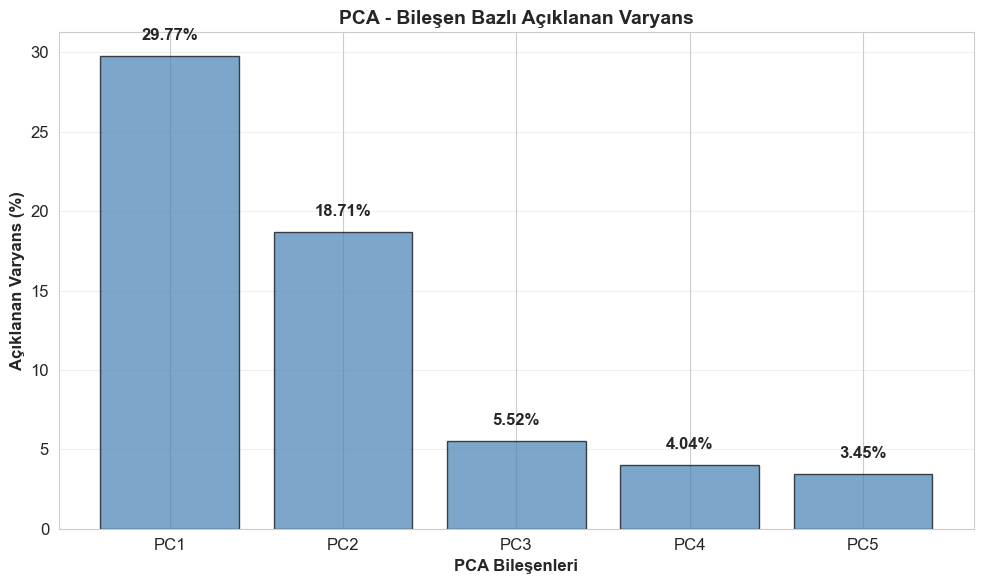

In [48]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
print("Boyut İndirgeme (PCA)")
print("PCA sadece X_train üzerinde fit edilmiş (öğrenilmiş), X_test'e transform edilmiştir.")
# -----------------------------------------------------------------------------
# PCA İŞLEMİ
# Sadece orijinal 64 kodon sütunu üzerinde PCA yapıyoruz.
# -----------------------------------------------------------------------------

# 1. Scaling (Sadece Kodonlar İçin)
scaler_pca = StandardScaler()
# Train setine fit_transform
X_train_codons_scaled = scaler_pca.fit_transform(train_df[codon_cols])
# Test setine transform (Train istatistikleri ile)
X_test_codons_scaled = scaler_pca.transform(test_df[codon_cols])

# 2. PCA Uygulama (5 Bileşen)
pca = PCA(n_components=5)
# Train setine fit_transform
X_train_pca = pca.fit_transform(X_train_codons_scaled)
# Test setine transform
X_test_pca = pca.transform(X_test_codons_scaled)

# Açıklanan varyans
explained_var = pca.explained_variance_ratio_
print("\n PCA Tamamlandı!")
print(f"   • Bileşen Sayısı: 5")
print(f"   • Açıklanan Toplam Varyans: {explained_var.sum()*100:.2f}%")
for i, var in enumerate(explained_var):
    print(f"   • PC{i+1}: {var*100:.2f}%")

# PCA sütunlarını ekle
for i in range(5):
    train_df[f'PCA_{i+1}'] = X_train_pca[:, i]
    test_df[f'PCA_{i+1}'] = X_test_pca[:, i]


plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), explained_var * 100, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('PCA Bileşenleri', fontsize=12, fontweight='bold')
plt.ylabel('Açıklanan Varyans (%)', fontsize=12, fontweight='bold')
plt.title('PCA - Bileşen Bazlı Açıklanan Varyans', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6), [f'PC{i}' for i in range(1, 6)])
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(explained_var):
    plt.text(i+1, v*100 + 1, f'{v*100:.2f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [51]:
# FİNAL VERİ HAZIRLAMA VE CSV KAYIT
print("\n" + "="*70)
print("Final Veri Hazırlama ve CSV Kayıt")
print("="*70)

# Modellemede kullanılmayacak sütunları çıkar
drop_cols = ['Kingdom', 'DNAtype', 'Ncodons']

# X ve y ayırımı
X_train_final = train_df.drop(columns=drop_cols + ['Kingdom_Encoded'], errors='ignore')
y_train_final = train_df['Kingdom_Encoded']
y_train_original = train_df['Kingdom']

X_test_final = test_df.drop(columns=drop_cols + ['Kingdom_Encoded'], errors='ignore')
y_test_final = test_df['Kingdom_Encoded']
y_test_original = test_df['Kingdom']

# CSV olarak kaydet
X_train_final.to_csv('X_train_processed.csv', index=False)
X_test_final.to_csv('X_test_processed.csv', index=False)
y_train_final.to_csv('y_train_processed.csv', index=False, header=['Kingdom_Encoded'])
y_test_final.to_csv('y_test_processed.csv', index=False, header=['Kingdom_Encoded'])

# Orijinal Kingdom'ları da kaydet
y_train_df = pd.DataFrame({
    'Kingdom_Encoded': y_train_final,
    'Kingdom_Original': y_train_original
})
y_test_df = pd.DataFrame({
    'Kingdom_Encoded': y_test_final,
    'Kingdom_Original': y_test_original
})

y_train_df.to_csv('y_train_with_names.csv', index=False)
y_test_df.to_csv('y_test_with_names.csv', index=False)

print("\n VERİ HAZIRLAMA TAMAMLANDI!")
print("\n Oluşturulan Dosyalar:")
print("   1. X_train_processed.csv - Eğitim özellikleri")
print("   2. X_test_processed.csv - Test özellikleri")
print("   3. y_train_processed.csv - Eğitim hedef (encoded)")
print("   4. y_test_processed.csv - Test hedef (encoded)")
print("   5. y_train_with_names.csv - Eğitim hedef (isimli)")
print("   6. y_test_with_names.csv - Test hedef (isimli)")



print(f"\n Final Veri Boyutları:")
print(f"   • X_train: {X_train_final.shape}")
print(f"   • X_test: {X_test_final.shape}")
print(f"   • Toplam Özellik: {X_train_final.shape[1]}")
print(f"   • Sınıf Sayısı: {len(y_train_final.unique())}")


Final Veri Hazırlama ve CSV Kayıt

 VERİ HAZIRLAMA TAMAMLANDI!

 Oluşturulan Dosyalar:
   1. X_train_processed.csv - Eğitim özellikleri
   2. X_test_processed.csv - Test özellikleri
   3. y_train_processed.csv - Eğitim hedef (encoded)
   4. y_test_processed.csv - Test hedef (encoded)
   5. y_train_with_names.csv - Eğitim hedef (isimli)
   6. y_test_with_names.csv - Test hedef (isimli)

 Final Veri Boyutları:
   • X_train: (10422, 92)
   • X_test: (2606, 92)
   • Toplam Özellik: 92
   • Sınıf Sayısı: 11
